In [11]:
#%matplotlib inline
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from numpy import sin, cos, sqrt, array, linspace

### Tripartite system: $H_{hyb}$

Fig 2b
Fig 1b

$\omega_a$=1500, $\omega_L$=1000

$g_{ac}=g_{am}$=50

In [32]:
#Total H for tripartit Sys. 
#No displacement

def mean_steady(w_m, w_L, Delta_aL, w_cLlist, g_cm, g_am, g_ac, n_th, kappa, gamma, F_L):
    N = 5 #5                  # number of cavity fock states
    M = 11 #9                  # number of phonon fock states   
   
    a = tensor(destroy(N), qeye(M), qeye(2))
    b = tensor(qeye(N), destroy(M), qeye(2))
    sigma_z = tensor(qeye(N), qeye(M), sigmaz())
    sigma_p = tensor(qeye(N), qeye(M), sigmap())  # raising and lowering ops for atom
    sigma_m = tensor(qeye(N), qeye(M), sigmam())
    
    num_a = a.dag() * a 
    num_b = b.dag() * b  

    c_ops = []
    gamma_a = gamma                           # Atom decay rate
    rate = kappa                              # kappa is cavity decay rate
    if rate > 0.0 : 
        c_ops.append(a * sqrt(rate))
    rate = n_th * gamma                       # gamma is decay for mechanical resonator 
    if rate > 0.0: 
        c_ops.append(b.dag() * sqrt(rate))
    rate = (n_th+1) * gamma
    if rate > 0.0 : 
        c_ops.append(b * sqrt(rate))
    rate = gamma_a
    if rate > 0.0 : 
        c_ops.append(sigma_m * sqrt(rate))
    idx = 0 
    n   = np.zeros(shape(w_cLlist))          # photon number 
    #n   = np.zeros(shape(delta_list))
    ######
    for w_c in w_cLlist:  
        
        H_Cav  = -(w_L - w_c) * num_a             #
        H_Atm  =  0.5 * (Delta_aL) *sigma_z            # 
        H_Mech =  w_m * num_b                          #
        #### Interaction  Hamiltonian
        H_Int  = 1j * g_ac * (sigma_p * a - sigma_m * a.dag())- g_cm * num_a *(b.dag() + b)- g_am * (sigma_z+1) * (b.dag() + b) 
        # Laser drive 
        H_drive   =  1j* F_L *(a.dag()-a)   
        ##### Total H: 
        H =  H_Cav + H_Atm + H_Mech + H_Int + H_drive #+ H_0

        solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
        ## only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
        use_rcm = False
        rho = steadystate(H, c_ops, method=solvers[2], tol=1e-15) # ,use_rcm=use_rcm ,use_precond=True,
        n[idx] = expect(a.dag()*a,rho)

        idx +=1
    ### H_0  when detuning is zero , no coupling    
    H_Atm1  = 0.5 * (Delta_aL) *sigma_z
    H0      = H_Atm1 + w_m * num_b  + H_drive
    return  n, c_ops, a, H0 

### Varaibles

In [33]:
Set = 3               ##### set of Parametrs    

if (Set==1):
    w_a  = 1500      #[ 1500 ]   [1052  ]
    w_L  =  1000 
    g_am = 50         #[  50   ]  [.54    ] 
    g_ac =  50   
elif Set==2:
    w_a  = 10520      #[ 15000 ]  [10520  ]
    w_L =  10000 
    g_am = 0.54      #[  50   ]   [.54     ]
    g_ac =  500
elif Set==3: 
    w_a  = 15000      #[ 15000 ]  [10520  ]
    w_L =  10000 
    g_am = 50      #[  50   ]   [.54     ]
    g_ac =  500   

w_m  = 1                       # mechanical frequency
n_th_i   = [0, 0, 1, 0 ]
gamma    = w_m/20.                                ## gamma is decay for mechanical resonator 
kappa_i  = [w_m/2., 2. * w_m, w_m/2., w_m/2.]     # kappa is cavity decay rate
g_cm = 0.001 * w_m               # cavity-resonator couplng  10 ^-5
Delta_aL = w_a - w_L
shift = g_ac**2/Delta_aL
shift

50.0

In [34]:
minn_c = w_L + shift + 6  #    w_L + 490
maxx_c = w_L + shift -6   #    w_L + 470
w_cLlist = np.linspace((minn_c )* w_m, (maxx_c ) * w_m, 11)  # so \Delta change between [-465, -495]     

shift = g_ac**2/Delta_aL
kappa = kappa_i[2]
n_th  = n_th_i[2]
F_L   = sqrt(kappa) * 0.01
n, c_ops, a, H0= mean_steady(w_m, w_L, Delta_aL, w_cLlist, g_cm, g_am, g_ac, n_th, kappa, gamma, F_L)

n0= n[1]
n0

6.918744846074249e-06

In [35]:
n0= n[-1]
n0

2.4660171294588483e-06

In [7]:
#w_c  = w_L +(g_ac**2)/Delta_aL

alpha = g_am * (1-(g_ac/Delta_aL)**2) 
shift = g_ac**2/Delta_aL
g_eff = g_cm + 2 * g_am * (g_ac/Delta_aL)**2
g_eff

1.0010000000000001

### Figure

100%|██████████| 4/4 [05:50<00:00, 87.67s/it]


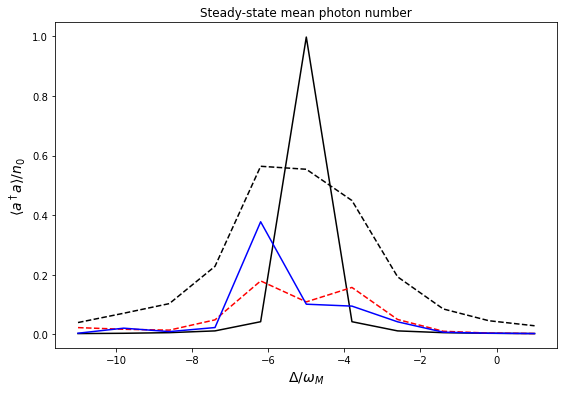

In [8]:
tlist = np.linspace(0, 100.0, 800)        # Time evolution
fig, ax= plt.subplots(1,1,figsize=(9,6))
linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']


Delta_aL = w_a - w_L
g_am_i = [0, g_am, g_am, g_am]
minn_c = w_L + shift + 6  #    w_L + 490
maxx_c = w_L + shift -6   #    w_L + 470

w_cLlist = np.linspace((minn_c )* w_m, (maxx_c ) * w_m, 11)  # so \Delta change between [-465, -495]     
#### to save data
xplot = []                                 #######=====###########====####
pllot2b  = np.zeros((len(w_cLlist),4))       ############tlist
#pllot4aa  = np.zeros((len(w_cLlist),4))       ############wlist

for i in tqdm([0, 1, 2, 3 ]): #[0, 1, 2, 3]:
    g_am  = g_am_i[i]
    shift = g_ac**2/Delta_aL
    kappa = kappa_i[i]
    n_th  = n_th_i[i]
    F_L   = sqrt(kappa) * 0.01        #   Laser amplitude        
    n, c_ops, a, H0 = mean_steady(w_m, w_L , Delta_aL, w_cLlist, g_cm, g_am, g_ac, n_th, kappa, gamma, F_L)    

    solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
    # only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
    use_rcm = False        
    #  <n_0>
    #rho0 = steadystate(H0, c_ops, method=solvers[2], tol=1e-14)  ### to
    #n_0 = expect(a.dag()*a,rho0) 
    n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
    
    ax.plot(w_L - w_cLlist , n/n_0, linestyle =linestyle[i], color=color[i])
    
    xplot = w_L - w_cLlist
    pllot2b[: , i] = n/n_0
        
ax.set_xlabel(r'$\Delta/ \omega_M $', fontsize=14)
ax.set_ylabel(r'$\langle a^ \dagger a  \rangle /n_0 $', fontsize=14)    # (r'$ e $',fontsize=16,color='red')
ax.set_title('Steady-state mean photon number')
#######        
plt.savefig("SteaSt_Mean_Hyb_NoDis_Modi_1500.pdf") # , dpi=50
plt.show()

In [ ]:

data2b = np.column_stack([xplot, pllot2b[: , 0],pllot2b[: , 1] ,pllot2b[: , 2], pllot2b[: , 3]])
np.savetxt("Fig2b1500Modf_SS.txt" , data2b, fmt=['%s','%s','%s','%s','%s'])

linestyle =['-.','-','--','--','-']
color=['t','black', 'black', 'r', 'b']
fig, ax= plt.subplots(1,1,figsize=(8,8))
for i in [1,2,3,4]:
    plt.plot(xplot, data2b[:,i], linestyle = linestyle[i], color = color[i])
    
ax.set_xlim([-8,8])
ax.set_ylim([0,1])
plt.show()
plt.savefig("SteaSt_MeanPhoton_Modi_2b_1500.pdf", dpi=150)

### Fig 2b 3partite

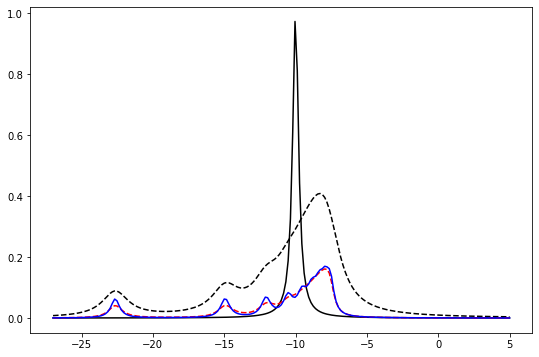

In [24]:

xarray = xplot
black = pllot2b[: , 0]
bblack = pllot2b[: , 1]
red = pllot2b[: , 2]
blue = pllot2b[: , 3]
data2b = np.column_stack([xarray, black , bblack,red ,blue])
np.savetxt("Fig2b.txt" , data2b, fmt=['%s','%s','%s','%s','%s'])

linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']
fig, ax= plt.subplots(1,1,figsize=(9,6))
for i in [1,2,3,4]:
    plt.plot(xarray-10, data2b[:,i], linestyle = linestyle[i-1], color = color[i-1])
    
plt.savefig("SteaSt_Mean_Hyb_NoDis_Modi1500.pdf", dpi=150) # , dpi=50

plt.show()

100%|██████████| 4/4 [1:20:02<00:00, 1200.70s/it]


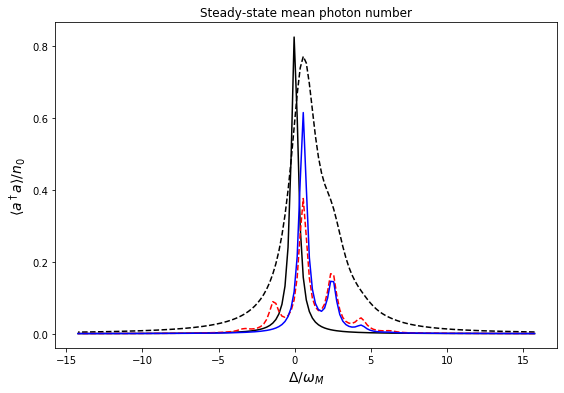

In [22]:
tlist = np.linspace(0, 100.0, 700)
fig, ax= plt.subplots(1,1,figsize=(9,6))
linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']

for j in [0]:
    w_a  = w_a_j[j]  
    w_L  = w_L_j[j]
    Delta_aL = w_a - w_L
    
    g_am_i1 = g_am_j[j] 
    g_ac = g_ac_j[j]
    #g_ef = g_cm + 2 * g_am * (g_ac/w_a)**2
    #g_i = [0, g_ef, g_ef,g_ef]
    g_am_i = [0, g_am_i1, g_am_i1, g_am_i1 ]
    minn_c = w_L + 465 #- shift  #minn_c = w_L - 4
    maxx_c = w_L + 495 #+ shift  #maxx_c = w_L + 11
    w_cLlist = np.linspace((minn_c )* w_m, (maxx_c ) * w_m, 151)

    #pllot1b  = np.zeros((len(w_cLlist),4))
    #xplot = []
    
    for i in tqdm([0, 1, 2, 3 ]): #[0, 1, 2, 3]:

        g_am = g_am_i[i]
        shift = g_ac**2/Delta_aL
        kappa = kappa_i[i]
        n_th            = n_th_i[i]
        F_L   = sqrt(kappa) * 0.01        # 
        n, c_ops, a, H0 = mean_steady(w_m, w_L , Delta_aL, w_cLlist, g_cm, g_am, g_ac, n_th, kappa, gamma, F_L)    

        solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
        # only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
        use_rcm = False
        rho0 = steadystate(H0, c_ops, method=solvers[2], tol=1e-14)
        n_0 = expect(a.dag()*a,rho0) 
    
        #xplot = w_L - w_cLlist/w_m + shift
        #pllot1b[: , i] = n/n_0
        
        ax.plot(w_L - w_cLlist/w_m + shift, n/n_0, linestyle =linestyle[i], color=color[i])
        ax.set_xlabel(r'$\Delta/ \omega_M $', fontsize=14)
        ax.set_ylabel(r'$\langle a^ \dagger a  \rangle /n_0 $', fontsize=14)    # (r'$ e $',fontsize=16,color='red')
        ax.set_title('Steady-state mean photon number')
#######

#######        
plt.savefig("SteaSt_Mean_Hyb1bb.pdf") # , dpi=50
plt.show()

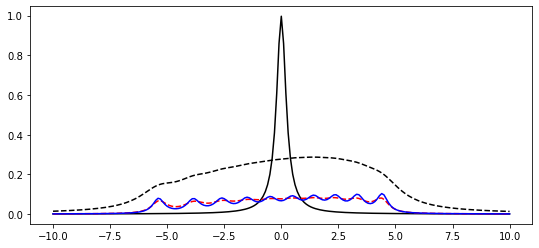

In [13]:
# No Dis , Delta_aL = 5000
xarray = xplot
black = pllot1b[: , 0]
bblack = pllot1b[: , 1]
red = pllot1b[: , 2]
blue = pllot1b[: , 3]
data1b = np.column_stack([xarray, black , bblack,red ,blue])
np.savetxt("Fig1b.txt" , data1b, fmt=['%s','%s','%s','%s','%s'])

linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']
fig, ax= plt.subplots(1,1,figsize=(9,4))
for i in [1,2,3,4]:
    plt.plot(xarray, data1b[:,i], linestyle = linestyle[i-1], color = color[i-1])
plt.show()

In [9]:
def mean_steady(w_m, w_a, g_cm, g_am, g_ac, delta_Llist, n_th, kappa, gamma, F_L):
    N = 5 #5                  # number of cavity fock states
    M = 10 #9                  # number of phonon fock states   
    
    alpha = g_am * (1-(g_ac/w_a)**2)              # v
    
    a = tensor(destroy(N), qeye(M), qeye(2))
    b = tensor(qeye(N), destroy(M), qeye(2))
    sigma_z = tensor(qeye(N), qeye(M), sigmaz())
    sigma_p = tensor(qeye(N), qeye(M), sigmap())  # raising and lowering ops for atom
    sigma_m = tensor(qeye(N), qeye(M), sigmam())
    
    num_a = a.dag() * a 
    num_b = b.dag() * b  

    c_ops = []
    gamma_a = 0 #0.5 * gamma
    rate = kappa                              # kappa is cavity decay rate
    if rate > 0.0 : 
        c_ops.append(a * sqrt(rate))
    rate = n_th * gamma                       # gamma is decay for mechanical resonator 
    if rate > 0.0: 
        c_ops.append(b.dag() * sqrt(rate))
    rate = (n_th+1) * gamma
    if rate > 0.0 : 
        c_ops.append(b * sqrt(rate))
    rate = gamma_a
    if rate > 0.0 : 
        c_ops.append(sigma_m * sqrt(rate))
    idx = 0 
    n   = np.zeros(shape(delta_Llist))
    ######
    ###### 
    #psi0 = tensor(basis(N,1),basis(M,4),basis(2,1));
    #tlist1 = np.linspace(0, 100.0, 1500)
    
    #opt=Options(rhs_reuse=True, nsteps=9000)        ##### have to big enough
    #opt=Options(nsteps=7000)
    for delta_LR in delta_Llist:    
        
        H_Cav  = -(delta_LR) * num_a #+ (2* alpha * g_cm/w_m - w_c -delta_LR) * num_a
        #H_Atm  = 0.5 * (w_a) *sigma_z #+ (2* alpha * g_am/w_m) * sigma_z #  ????? -(delta_LR)
        H_Mech =  w_m * num_b + alpha * (b.dag() + b) # 
        #### Interaction  Hamiltonian
        #H_Int  = 1j * g_ac * (sigma_p * a - sigma_m * a.dag())- g_cm * num_a *(b.dag() + b)- g_am * sigma_z * (b.dag() + b) 
        g_eff = g_cm + 2 * g_am * (g_ac/w_a)**2
        H_Int =  - g_eff  * num_a* (b.dag() + b)
        # Laser drive 
        H_drive   = 1j* F_L *(a.dag()-a)   
        ### constant value 
        #H_0 = (alpha**2)/w_m               ## +
        ##### Total H: 
        H =  H_Cav  + H_Mech + H_Int + H_drive #+ H_0

        #########################
        ########################
        solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
        ## only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
        use_rcm = False
        rho = steadystate(H, c_ops, method=solvers[2], tol=1e-14) # ,use_rcm=use_rcm ,use_precond=True,
        n[idx] = expect(a.dag()*a,rho)
        #########################
        #########################
        #opts = Options(ntraj=500) # rhs_reuse=True,
        #n0 = mcsolve(H, psi0, tlist1, c_ops, [a.dag() * a],options=opts).expect[0]
        ##########################

        idx +=1

    H0 = 0 * H_Cav + w_m * num_b + 0 * H_Int + H_drive   # H at resonance

    return  n, c_ops, a, H0

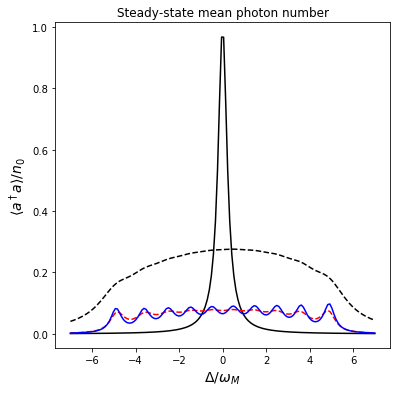

In [10]:
w_m  = 1                       # mechanical frequency
w_c  = 700. * w_m              # ??
###### calculation for two alternative sets (both g_eff = w_m)
#################################

w_a_i  = [800 * w_m, 1250 * w_m       , 800 * w_m      , 1044 * w_m     ]
g_am_i = [0        , 69. * w_m        , 63. * w_m      , 61. * w_m      ]
g_ac_i = [0        , 69. * 1.542 * w_m, 63. * 1.13* w_m, 61. * 1.55* w_m]

n_th_i   = [0, 0, 1, 0 ]
gamma    = w_m/20.                                ## gamma is decay for mechanical resonator 
kappa_i  = [w_m/2., 2. * w_m, w_m/2., w_m/2.]     # kappa is cavity decay rate
g_cm = 0.01 * w_m               # cavity-resonator couplng  10 ^-5

delta_Llist = np.linspace(-7 * w_m, 7 * w_m, 150)          # omega_L range 
tlist = np.linspace(0, 100.0, 1000)
opt=Options(rhs_reuse=True, nsteps=2500)

fig, ax= plt.subplots(1,1,figsize=(6,6))
linestyle =['-','--','--','-']
color=['black', 'black', 'r', 'b']

#for j in [0]:
#w_a  = w_a_j[0]  
#g_am = g_am_j[0] 
#g_ac = g_ac_j[0]

for i in [0, 1, 2, 3]: #[0, 1, 2, 3]:
    w_a   =  w_a_i[i]
    g_am  =  g_am_i[i]
    g_ac  =  g_ac_i[i]
    #g_eff = g_cm + 2 * g_am * (g_ac/w_a)**2
    kappa = kappa_i[i]
    n_th            = n_th_i[i]
    F_L   = sqrt(kappa) * 0.01        # small?
    
    n_A, c_ops, a, H0 = mean_steady(w_m, w_a, g_cm, g_am, g_ac, delta_Llist, n_th, kappa, gamma, F_L)    
    #n_0 = 4 * (F_L/kappa)**2
    solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
    # only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
    use_rcm = False
    rho0 = steadystate(H0, c_ops, method=solvers[2], tol=1e-14)
    n0 = mesolve(H0, rho0, tlist, c_ops, [a.dag() * a]).expect[0]  #, options=opt
    n_0 = n0[-1]  

    ax.plot(delta_Llist/w_m , n_A/n_0, linestyle =linestyle[i], color=color[i])
    
ax.set_xlabel(r'$\Delta/ \omega_M $', fontsize=14)
ax.set_ylabel(r'$\langle a^ \dagger a  \rangle /n_0 $', fontsize=14)    # (r'$ e $',fontsize=16,color='red')
ax.set_title('Steady-state mean photon number')
#ax.set_xlim([-7*w_m,7*w_m])
        #ax[j].set_ylim([0,5])   # ([0,max(spec)])
plt.savefig("SteaSt_MeanPhoton_Hybrid_Analitical.pdf") # , dpi=50
plt.show()
